# Hypothesis testing 

In this section we determine if the average travel time among different socio-demographics, in this case strata, are statistically significant. Additionally, we hypothesize that the lower the strata, the longer the travel time. Therefore, we posit the following hypothesis: 

- $H_0 : \mu_1 = \mu_2 $ 
- $H_0 : \mu_1 = \mu_3 $
- $H_0 : \mu_1 = \mu_4 $
- $H_0 : \mu_1 = \mu_5 $
- $H_0 : \mu_2 = \mu_3 $
- $H_0 : \mu_2 = \mu_4 $
- $H_0 : \mu_2 = \mu_5 $
- $H_0 : \mu_3 = \mu_4 $
- $H_0 : \mu_3 = \mu_5 $
- $H_0 : \mu_4 = \mu_5 $

Where the $\mu_j$ is the average travel time of strata j. Respectively, the alternative hypothesis are:

- $H_1 : \mu_1 > \mu_2 $ 
- $H_1 : \mu_1 > \mu_3 $
- $H_1 : \mu_1 > \mu_4 $
- $H_1 : \mu_1 > \mu_5 $
- $H_1 : \mu_2 > \mu_3 $
- $H_1 : \mu_2 > \mu_4 $
- $H_1 : \mu_2 > \mu_5 $
- $H_1 : \mu_3 > \mu_4 $
- $H_1 : \mu_3 > \mu_5 $
- $H_1 : \mu_4 > \mu_5 $

To test these hypothesis, we will use a t-statistic, and a confidence interval $\alpha = 0.95$. The t-statistic is define as follows: 

$ t-statistic = \frac{\bar{\mu_1} - \bar{\mu_1}}{\sqrt{\frac{\sigma_1^2}{n_1} + \frac{\sigma_2^2}{n_1}}} $

We will test travel time in both directions, HOME-to-WORK and WORK-to-HOME. 

In [3]:
import os; os.chdir('../..')
import warnings
warnings.filterwarnings('ignore')

In [4]:
import pandas as pd
import numpy as np
import pandas.io.sql as sqlio
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
import time
import geopandas as gpd
from itertools import combinations
import scipy.stats as st

In [5]:
HW = pd.read_csv(os.getcwd() + '/08_Results/HW_location.csv')
tm_skims = pd.read_csv(os.getcwd() + '/07_Notebooks/cp255/data/tm_skims.csv')

## Merging travel times to users table

In [6]:
skims = pd.melt(tm_skims, id_vars = ['origin_id', 'destination_id'],
        value_vars = ['4_7', '7_10', '10_13', '13_16', '16_19','19_22'],
        var_name = 'period', value_name = 'travel_time')

In [7]:
HW['HW_period'] = pd.cut(HW.rank1_time, bins = [0,7,10,13,16,19,24], 
       labels = ['4_7', '7_10', '10_13', '13_16', '16_19', '19_22'])

HW['WH_period'] = pd.cut(HW.rank2_time, bins = [0,7,10,13,16,19,24], 
       labels = ['4_7', '7_10', '10_13', '13_16', '16_19', '19_22'])

In [8]:
#Merging travel times for HOME-WORK and WORK-HOME
HW = HW.merge(skims, how = 'left', left_on = ['home', 'work', 'HW_period'], 
         right_on = ['origin_id', 'destination_id', 'period'])

HW = HW.merge(skims, how = 'left', left_on = ['home', 'work', 'WH_period'], 
         right_on = ['origin_id', 'destination_id', 'period'], suffixes=('_HW', '_WH'))

In [9]:
HW.isnull().sum()

idnumerotarjeta           0
rank1                     0
rank2                  2128
rank1_time                0
rank2_time             2128
home                      0
ESTRATO                   0
home_lat                  0
home_lon                  0
work                   2128
work_lat               2128
work_lon               2128
HW_period                 0
WH_period              2128
origin_id_HW         263206
destination_id_HW    263206
period_HW            263206
travel_time_HW       263206
origin_id_WH         263206
destination_id_WH    263206
period_WH            263206
travel_time_WH       263206
dtype: int64

- There are some missing values. Missing values occured because the GTFS did not include the recent cablecar in the south of the city. 

TO DO: 
The cable car is located in a estrato 1 region, so we will aproximate the home station to the closest station to the cable car, which in this case is "Portal Tunal". In fact, users using the cable car will need to transfer at this location to board the BRT system. However, this will add more travel time for strata 1 users. 


In [10]:
HW = HW.dropna(subset=['destination_id_WH'])

In [11]:
HW.isnull().sum()

idnumerotarjeta      0
rank1                0
rank2                0
rank1_time           0
rank2_time           0
home                 0
ESTRATO              0
home_lat             0
home_lon             0
work                 0
work_lat             0
work_lon             0
HW_period            0
WH_period            0
origin_id_HW         0
destination_id_HW    0
period_HW            0
travel_time_HW       0
origin_id_WH         0
destination_id_WH    0
period_WH            0
travel_time_WH       0
dtype: int64

# Home - work travel times

In [12]:
x_1 = HW[HW.ESTRATO == 1].travel_time_HW
x_2 = HW[HW.ESTRATO == 2].travel_time_HW
x_3 = HW[HW.ESTRATO == 3].travel_time_HW
x_4 = HW[HW.ESTRATO == 4].travel_time_HW
x_5 = HW[HW.ESTRATO == 5].travel_time_HW

distributions = [x_1, x_2, x_3, x_4, x_5]
summary_table = pd.DataFrame({'Strata': [1,2,3,4,5]})

summary_table['sample_size'] = [len(x) for x in distributions]
summary_table['Average Travel Time'] = [x.mean() for x in distributions]
summary_table['Standard deviation'] = [x.std() for x in distributions]
summary_table['Variance'] = [np.var(x) for x in distributions]
summary_table

,Strata,sample_size,Average Travel Time,Standard deviation,Variance
0,1,918421,27.706606,11.949338,142.786521
1,2,3021902,22.463491,11.006309,121.138791
2,3,2129308,18.421185,10.412604,108.422267
3,4,307540,17.362999,10.402443,108.210473
4,5,30796,17.136014,10.497342,110.190603


Strata 1 and 2 have the highest average travel time with 27.7, and 22.4 minutes respectively. For higher strata, meaning 3,4, and 5, the mean travel time seems to be similar, with a variation of around 1 minute. 

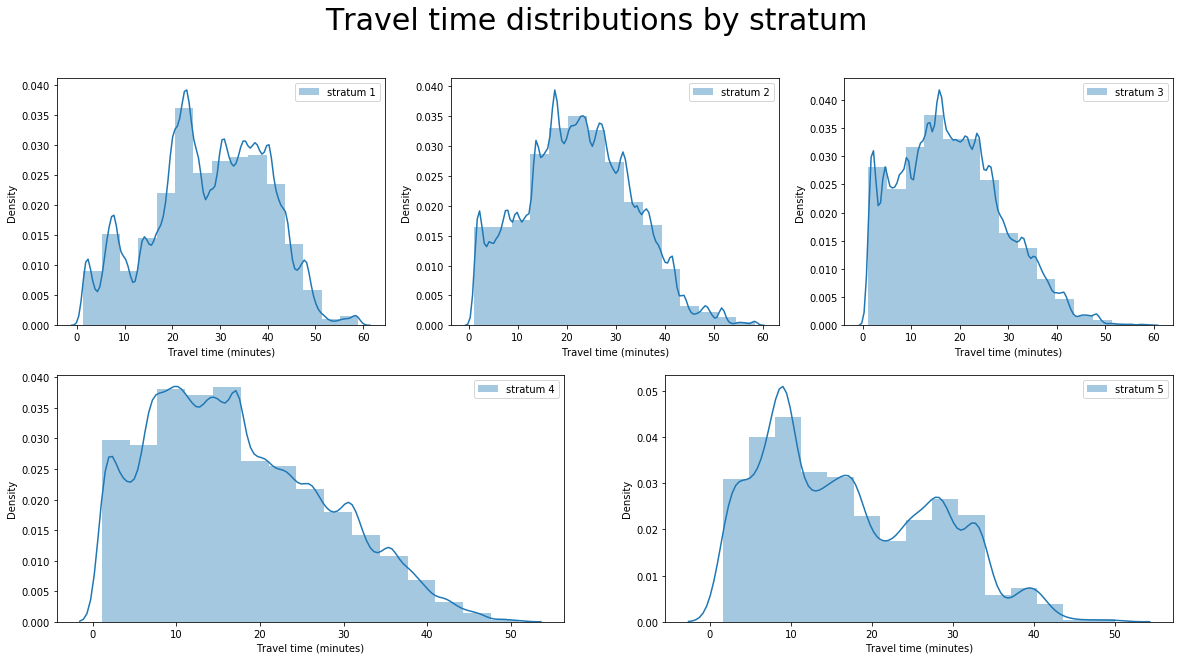

In [13]:
#Plotting travel time differences among estrata
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(223)
ax5 = fig.add_subplot(224)

axes = [ax1, ax2, ax3, ax4, ax5]
distributions = [x_1, x_2, x_3, x_4, x_5]

for x in range(len(axes)):
    label = "stratum " + str(x+1)
    sns.distplot(distributions[x], bins=15, ax = axes[x], label = label)
    axes[x].legend()
    axes[x].set_ylabel('Density')
    axes[x].set_xlabel('Travel time (minutes)')

fig.suptitle('Travel time distributions by stratum', fontsize=30);

Based on the travel time distributions, we cannot assume that they are normally distributed. The standard deviation seems to be wider for a normal distribution, and it tends to be sweked to the left, with a sharp cut at zero (no travel time can be less than zero). The best way to 

## Home-work tt hypothesis testing 

In [14]:
#Hypothesis one 
h = list(combinations(summary_table.Strata, 2))
hypothesis = pd.DataFrame(h, columns = ['x1', 'x2'])
hypothesis= hypothesis.merge(summary_table, how = 'inner', left_on = 'x1', right_on = 'Strata')
hypothesis = hypothesis.merge(summary_table, how = 'inner', left_on = 'x2', right_on = 'Strata',
                             suffixes=('_x1', '_x2'))

hypothesis['mean_diff'] =  hypothesis['Average Travel Time_x1'] - hypothesis['Average Travel Time_x2']
hypothesis['var_x1'] = hypothesis['Variance_x1']/hypothesis['sample_size_x1']
hypothesis['var_x2'] = hypothesis['Variance_x2']/hypothesis['sample_size_x2']
hypothesis['t-test'] = hypothesis['mean_diff']/(np.sqrt(hypothesis['var_x1']+hypothesis['var_x2']))
hypothesis['p-value'] = st.norm.sf(abs(hypothesis['t-test']))

hypothesis[['x1', 'x2', 'sample_size_x1', 'Average Travel Time_x1',
       'Standard deviation_x1', 'sample_size_x2',
       'Average Travel Time_x2', 'Standard deviation_x2', 
       'mean_diff', 'var_x1', 'var_x2', 't-test', 'p-value']].round(3)

,x1,x2,sample_size_x1,Average Travel Time_x1,Standard deviation_x1,sample_size_x2,Average Travel Time_x2,Standard deviation_x2,mean_diff,var_x1,var_x2,t-test,p-value
0,1,2,918421,27.707,11.949,3021902,22.463,11.006,5.243,0.0,0.000,374.933,0.0
1,1,3,918421,27.707,11.949,2129308,18.421,10.413,9.285,0.0,0.000,646.337,0.0
2,2,3,3021902,22.463,11.006,2129308,18.421,10.413,4.042,0.0,0.000,423.735,0.0
3,1,4,918421,27.707,11.949,307540,17.363,10.402,10.344,0.0,0.000,459.227,0.0
4,2,4,3021902,22.463,11.006,307540,17.363,10.402,5.100,0.0,0.000,257.632,0.0
5,3,4,2129308,18.421,10.413,307540,17.363,10.402,1.058,0.0,0.000,52.727,0.0
6,1,5,918421,27.707,11.949,30796,17.136,10.497,10.571,0.0,0.004,172.997,0.0
7,2,5,3021902,22.463,11.006,30796,17.136,10.497,5.327,0.0,0.004,88.568,0.0
8,3,5,2129308,18.421,10.413,30796,17.136,10.497,1.285,0.0,0.004,21.334,0.0
9,4,5,307540,17.363,10.402,30796,17.136,10.497,0.227,0.0,0.004,3.621,0.0


All the p-values are less than 0.95. This means that we reject all null hypothesis. Even small differences in travel time (such as those between strata 4 and 5) are statistically significant. 

# Work-Home travel times

In [15]:
x_1 = HW[HW.ESTRATO == 1].travel_time_WH
x_2 = HW[HW.ESTRATO == 2].travel_time_WH
x_3 = HW[HW.ESTRATO == 3].travel_time_WH
x_4 = HW[HW.ESTRATO == 4].travel_time_WH
x_5 = HW[HW.ESTRATO == 5].travel_time_WH

distributions = [x_1, x_2, x_3, x_4, x_5]
summary_table = pd.DataFrame({'Strata': [1,2,3,4,5]})

summary_table['sample_size'] = [len(x) for x in distributions]
summary_table['Average Travel Time'] = [x.mean() for x in distributions]
summary_table['Standard deviation'] = [x.std() for x in distributions]
summary_table['Variance'] = [np.var(x) for x in distributions]
summary_table

,Strata,sample_size,Average Travel Time,Standard deviation,Variance
0,1,918421,28.440505,12.256253,150.215573
1,2,3021902,23.547812,11.512400,132.535313
2,3,2129308,18.620950,10.504063,110.335278
3,4,307540,17.039316,10.152666,103.076285
4,5,30796,16.855643,10.161819,103.259209


The results are similar to those obtain in the Home-to-work travel times, however, it is important to notice that the difference among low and high strata is higher, 12 minutes instead of ten mins difference in the morning trip. 

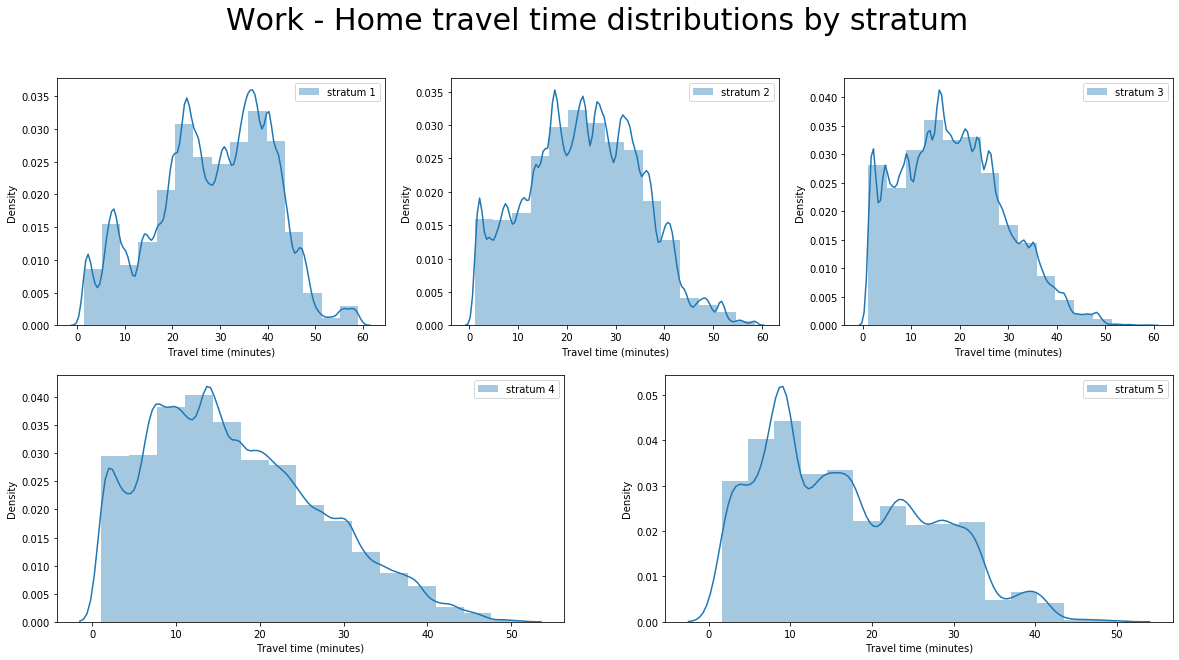

In [16]:
#Plotting travel time differences among estrata
fig = plt.figure(figsize = (20,10))

ax1 = fig.add_subplot(231)
ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(223)
ax5 = fig.add_subplot(224)

axes = [ax1, ax2, ax3, ax4, ax5]
distributions = [x_1, x_2, x_3, x_4, x_5]

for x in range(len(axes)):
    label = "stratum " + str(x+1)
    sns.distplot(distributions[x], bins=15, ax = axes[x], label = label)
    axes[x].legend()
    axes[x].set_ylabel('Density')
    axes[x].set_xlabel('Travel time (minutes)')

fig.suptitle('Work - Home travel time distributions by stratum', fontsize=30);

In [17]:
#Hypothesis one 
h = list(combinations(summary_table.Strata, 2))
hypothesis = pd.DataFrame(h, columns = ['x1', 'x2'])
hypothesis= hypothesis.merge(summary_table, how = 'inner', left_on = 'x1', right_on = 'Strata')
hypothesis = hypothesis.merge(summary_table, how = 'inner', left_on = 'x2', right_on = 'Strata',
                             suffixes=('_x1', '_x2'))

hypothesis['mean_diff'] =  hypothesis['Average Travel Time_x1'] - hypothesis['Average Travel Time_x2']
hypothesis['var_x1'] = hypothesis['Variance_x1']/hypothesis['sample_size_x1']
hypothesis['var_x2'] = hypothesis['Variance_x2']/hypothesis['sample_size_x2']
hypothesis['t-test'] = hypothesis['mean_diff']/(np.sqrt(hypothesis['var_x1']+hypothesis['var_x2']))
hypothesis['p-value'] = st.norm.sf(abs(hypothesis['t-test']))

hypothesis[['x1', 'x2', 'sample_size_x1', 'Average Travel Time_x1',
       'Standard deviation_x1', 'sample_size_x2',
       'Average Travel Time_x2', 'Standard deviation_x2', 
       'mean_diff', 'var_x1', 'var_x2', 't-test', 'p-value']].round(3)

,x1,x2,sample_size_x1,Average Travel Time_x1,Standard deviation_x1,sample_size_x2,Average Travel Time_x2,Standard deviation_x2,mean_diff,var_x1,var_x2,t-test,p-value
0,1,2,918421,28.441,12.256,3021902,23.548,11.512,4.893,0.0,0.000,339.724,0.000
1,1,3,918421,28.441,12.256,2129308,18.621,10.504,9.820,0.0,0.000,669.103,0.000
2,2,3,3021902,23.548,11.512,2129308,18.621,10.504,4.927,0.0,0.000,503.697,0.000
3,1,4,918421,28.441,12.256,307540,17.039,10.153,11.401,0.0,0.000,510.529,0.000
4,2,4,3021902,23.548,11.512,307540,17.039,10.153,6.508,0.0,0.000,334.309,0.000
5,3,4,2129308,18.621,10.504,307540,17.039,10.153,1.582,0.0,0.000,80.401,0.000
6,1,5,918421,28.441,12.256,30796,16.856,10.162,11.585,0.0,0.003,195.358,0.000
7,2,5,3021902,23.548,11.512,30796,16.856,10.162,6.692,0.0,0.003,114.823,0.000
8,3,5,2129308,18.621,10.504,30796,16.856,10.162,1.765,0.0,0.003,30.253,0.000
9,4,5,307540,17.039,10.153,30796,16.856,10.162,0.184,0.0,0.003,3.024,0.001


In [18]:
hypothesis[['x1', 'x2', 'Average Travel Time_x1',
       'Standard deviation_x1',
       'Average Travel Time_x2', 'Standard deviation_x2', 
       'mean_diff', 't-test', 'p-value']].round(3)

,x1,x2,Average Travel Time_x1,Standard deviation_x1,Average Travel Time_x2,Standard deviation_x2,mean_diff,t-test,p-value
0,1,2,28.441,12.256,23.548,11.512,4.893,339.724,0.000
1,1,3,28.441,12.256,18.621,10.504,9.820,669.103,0.000
2,2,3,23.548,11.512,18.621,10.504,4.927,503.697,0.000
3,1,4,28.441,12.256,17.039,10.153,11.401,510.529,0.000
4,2,4,23.548,11.512,17.039,10.153,6.508,334.309,0.000
5,3,4,18.621,10.504,17.039,10.153,1.582,80.401,0.000
6,1,5,28.441,12.256,16.856,10.162,11.585,195.358,0.000
7,2,5,23.548,11.512,16.856,10.162,6.692,114.823,0.000
8,3,5,18.621,10.504,16.856,10.162,1.765,30.253,0.000
9,4,5,17.039,10.153,16.856,10.162,0.184,3.024,0.001


Similar to the home-to-work trips, we fail to reject the null hypothesis. Therefore, the differences in travel times among strata are significally differente\. 

# Conclusions

All the p-values are significantly inferior that 0.95, our significance level. Thus, we reject the null hypothesis. This suggest that travel time in transit does increase when we lower the strata. On average, a strata 1 user spends 21 more minutes in the BRT than a strata 5 user (10 and 11 more minutes, in the morning and the afternoon respectively). In average, Colombia has 244 working days a year. That is a strata 1 person spends around 85,4 hours more in public transit a year. 